# Tarea 3 - Data Science

### **INF3831 - Bases de Datos**
**Profesor: Domagoj Vrgoč / Ayudante: Valentina Álvarez**

---

Durante esta tarea trabajaremos con los datos del sistema nacional de información municipal del gobierno de Chile. La idea es hacer un análisis de datos para ver cómo se relacionan ciertos atributos de los municipios (como por ejemplo, número de centros culturales o gasto total en educación) con los puntajes PSU en establecimientos municipales.

## Parte I - Cargar datos a SQLite
---

Tienes acceso a las siguientes fuentes de datos:

1. Un archivo csv llamado `municipios.csv` con las siguientes columnas: 

    - CODIGO: el identificador de cada municipio.
    - MUNICIPIO: su nombre.
    
    
2. Un archivo csv llamado `datos_municipales_caracterizacion.csv` con las siguientes columnas:

    - CODIGO: código del municipio.
    - ISC: (KMS²) Superficie Comunal (km2).
    - ICAR004: (N°) Población Comunal, Estimada por el INE.
    
     
3. Una archivo csv llamado `datos_municipales_sociales.csv`, que contiene las siguientes columnas:

    - CODIGO: código del municipio.
    - ISOC001: (%) Indice de Pobreza CASEN (Última Encuesta Vigente).
    - LPCASEN: (%) Porcentaje de Población en Condiciones de Pobreza, según CASEN.
    - MSUFO: (N°) Subsidios Familiares (SUF) Otorgados en la comuna.
    - MPIE: (N°) Personas Inscritas en la Municipalidad en Busca de Empleo.
    - MCCULT: (N°) N° de Centros Culturales.
    
**Importante:** Nunca grabes un .csv desde excel, porque excel puede cambiar la codificación de esos archivos. En caso de problemas, siempre puedes volver a bajar el .csv desde la página del curso.


In [2]:
# montar datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

conn = sqlite3.connect('municipios.db')
#conn.text_factory = lambda x: str(x, 'latin1')
#curr = conn.cursor()

### T1 [1 pto] - Cargar datos

Tu primera misión es cargar estos datos a una base de datos SQL. Para esto, tienes dos opciones:

- Importar los datos del csv a la base de datos utilizando Python. Una forma de hacer esto es la propuesta en [el siguente link](https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python) o
- Importar los datos del csv al .db directamente con SQLite3 (esta opción requiere que instales SQLite3 en tu computador).

Tendrás que generar las siguientes tablas:

- `municipios(codigo, municipio)`: que asigna a cada municipio en Chile un identificador y su nombre.
- `datos_sociales(codigo, ISOC001, LPCASEN, MSUFO, MPIE, MCCULT)`: que asigna a cada municipio información relacionada con aspectos sociales.
- `caracteristicas_municipio(codigo, ISC, ICAR004)`: que indica las características de población y territoriales de cada municipio.


In [4]:
#datos de los municipios
municipios=pd.read_csv('/content/drive/MyDrive/MIA/INF3831 - Bases de datos/Tarea 3/municipios.csv',sep=';')
municipios.to_sql("municipios", conn,if_exists='fail', index = False, chunksize = 10000)
#datos municipales de caracterizacion
caracteristicas_municipio=pd.read_csv('/content/drive/MyDrive/MIA/INF3831 - Bases de datos/Tarea 3/datos_municipales_caracterizacion.csv',sep=';',decimal=',')
caracteristicas_municipio.to_sql("caracteristicas_municipio", conn,if_exists='append', index = False, chunksize = 10000)
#datos municipales sociales
datos_sociales=pd.read_csv('/content/drive/MyDrive/MIA/INF3831 - Bases de datos/Tarea 3/datos_municipales_sociales.csv',sep=';',decimal=',')
datos_sociales.to_sql("datos_sociales", conn,if_exists='append', index = False, chunksize = 10000)

In [5]:
#municipios
pd.read_sql('SELECT * FROM municipios', conn)

,CODIGO,MUNICIPIO
0,1101,IQUIQUE
1,1107,ALTO HOSPICIO
2,1401,POZO ALMONTE
3,1402,CAMIÑA
4,1403,COLCHANE
...,...,...
340,16301,SAN CARLOS
341,16302,COIHUECO
342,16303,ÑIQUÉN
343,16304,SAN FABIÁN


### T2 [0.5 ptos] - Establecer valores nulos

Existen comunas que no tienen información sobre ciertos atributos, por lo que tu deber es establecer estos valores como nulos en la base de datos. Para esto, puedes utilizar el siguiente comando:

```sql
UPDATE table_name SET attribute = NULL WHERE codición;
```

Como hint, en la tabla `caracteristicas_municipios` tendrás que setear como nulos los valores de `ISC` que sean igual 'Sin dato oficial'. Para el caso de `datos_sociales` tendrás que setear como nulos los valores de `MSUFO`, `MPIE` y `MCCULT` que sean igual a 'No Recepcionado'.

In [6]:
curr = conn.cursor()
curr.execute("UPDATE caracteristicas_municipio SET ISC=NULL where ISC='Sin dato oficial'")
for columna in ['MSUFO','MPIE','MCCULT']:
  curr.execute(f"UPDATE datos_sociales SET {columna}=NULL where {columna}='No Recepcionado'")
conn.commit()
curr.close()

In [7]:
#despues:
pd.read_sql('SELECT * FROM caracteristicas_municipio where ISC is null', conn)

,CODIGO,ISC,ICAR004
0,11101,None,60822
1,11102,None,919
2,11201,None,24880
3,11202,None,5801
4,11203,None,1591
5,11301,None,3660
6,11302,None,655
7,11303,None,567
8,11401,None,5096
9,11402,None,2689


In [8]:
#despues:
pd.read_sql('SELECT * FROM datos_sociales where MSUFO is null or MPIE is null or MCCULT is null', conn)

,CODIGO,ISOC001,LPCASEN,MSUFO,MPIE,MCCULT
0,1401,10.88,11,None,None,None
1,1403,13.95,14,None,None,None
2,2104,3.51,4,None,None,None
3,2203,4.04,4,None,None,None
4,2301,10.40,10,None,None,None
5,3101,6.26,6,None,None,None
6,4104,20.54,21,None,363,3
7,4201,12.02,12,None,None,None
8,4203,13.81,14,None,None,None
9,4301,5.74,6,None,None,None


## Parte II - Análisis de datos
---

Ahora, además de contar con la base de datos que creaste en la parte anterior, tienes acceso al archivo `datos_municipales_educacion.csv` que tiene las siguientes columnas:

- CODIGO: código del municipio
- IEDU005: (%) Porcentaje de Asistencia Escolar Comunal
- IEDU011: (%) Porcentaje de Puntajes PSU Igual o Superior a 450 Puntos en Establecimientos Municipales de Educación
- IEDU018: (M\$) Subvención de Escolaridad (del Mineduc)
- IEDU025: (M\$) Gastos Educación (Gasto Total Devengado)
- IEDU035: (PERS) Número de Alumnos por Docente de Aula (Fuente: MINEDUC)

### T3 [0.5 ptos] - Crear dataframes

Crea los dataframes correspondientes para guardar la información:
- En el caso de la información que viene de la base de datos, tendrás que ejecutar las consultas correspondientes para crear los dataframes. 
- En el caso del csv con datos de educación, tendrás que cargarlos directamente con pandas. Una vez creado este dataframe,  tendrás que reemplazar los valores de 'No Recepcionado' y de 'Sin Servicio' a `np.nan`.

In [9]:
#datos municipales de educacion
datos_educacion=pd.read_csv('/content/drive/MyDrive/MIA/INF3831 - Bases de datos/Tarea 3/datos_municipales_educacion.csv',sep=';',decimal=',',na_values=['No Recepcionado','Sin Servicio'])

In [10]:
datos_educacion

,CODIGO,IEDU005,IEDU011,IEDU018,IEDU025,IEDU035
0,1101,79.90,31.74,14994697.0,36304957.0,20.11
1,1107,81.92,60.76,4293683.0,6218158.0,20.13
2,1401,85.12,27.04,6609770.0,9358336.0,22.34
3,1402,91.56,12.50,633380.0,1744612.0,11.84
4,1403,82.94,20.00,415662.0,1130047.0,8.10
...,...,...,...,...,...,...
340,16301,90.82,39.74,7670037.0,15602246.0,11.46
341,16302,91.44,48.48,4398201.0,6585446.0,10.90
342,16303,88.21,34.09,3492336.0,6132479.0,10.37
343,16304,92.75,57.50,1512666.0,3086471.0,12.47


### T4 [1.5 ptos] - Análisis centro culturales por km2 vs puntajes PSU 

Crea un gráfico de puntos para visualizar la correlación entre la cantidad de centros culturales del municipio por km2 y el porcentaje de puntajes PSU igual o sobre los 450 puntos en establecimientos municipales. Luego calcula la correlación y establece alguna conclusión al respecto. 

Ojo que primero tendrás que limpiar los datos con los que vas a trabajar: no consideres los datos nulos, aunque eso signifique dejar algunas comunas fuera del análisis. Procura eliminar esos valores solo para este análisis puntual, ya que para los siguientes, puede que esas comunas sí tengan la información que necesitas. Por ejemplo, en este análisis estarás trabajando con los atributos ISC, MMCULT y IEDU011, entonces puedes dejar fuera a las comunas que tengan alguno de estos atributos nulos, pero no puedes dejar fuera comunas que tengan LPCASEN con valores nulos porque simplemente no lo estarás utilizando. Por lo mismo, las comunas que elimines tampoco pueden ser eliminadas definitivamente de tus dataframes, ya que en análisis posteriores, puede que esas mismas comunas no tengan los atributos que utilizarás con valores nulos. 

También tendrás que tener cuidado con los tipos de datos (int, string).

**HINT: recuerda que se pide analizar la cantidad de centros culturales por km2 por lo que tendrás que dividir ambos valores.**

Text(0, 0.5, 'Porcentaje PSU>=450')

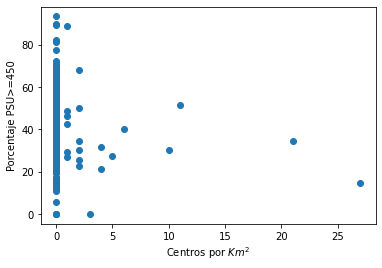

In [11]:
query='''SELECT caracteristicas_municipio.codigo,datos_sociales.MCCULT/caracteristicas_municipio.ISC as centros_por_km2
FROM datos_sociales,caracteristicas_municipio 
where datos_sociales.MCCULT is not null 
and caracteristicas_municipio.ISC is not null 
and datos_sociales.codigo=caracteristicas_municipio.codigo'''
data_final=pd.read_sql(query, conn)
data_final=data_final.merge(datos_educacion,on='CODIGO')
plt.scatter(data_final['centros_por_km2'],data_final['IEDU011'])
plt.xlabel('Centros por $Km^2$')
plt.ylabel('Porcentaje PSU>=450')

### T5 [1.5 ptos] - Análisis gasto en educación por habitante vs puntajes PSU 

Crea un gráfico de puntos para visualizar la correlación entre el gasto en educación por habitante de la comuna y el porcentaje de puntajes PSU igual o sobre los 450 puntos en establecimientos municipales. Luego calcula la correlación y establece alguna conclusión al respecto. 

Al igual que en la pregunta anterior, tendrás que limpiar los datos con los que vas a trabajar, siguiendo la misma regla.

**HINT: recuerda que se pide analizar el gasto en edicación por habitante, por lo que tendrás que dividir ambos valores.**

Text(0.5, 49.99999999999995, 'Gastos por habitiante')

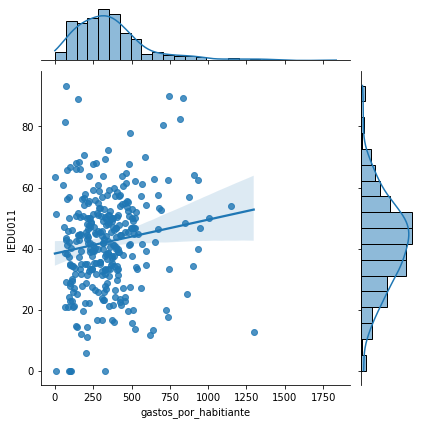

In [16]:
import seaborn as sns
query='''SELECT codigo,ICAR004
FROM caracteristicas_municipio'''
data_final2=pd.read_sql(query, conn)
data_final2=data_final2.merge(datos_educacion,on='CODIGO')
data_final2['gastos_por_habitiante']=data_final2.IEDU025/data_final2.ICAR004
sns.jointplot(x="gastos_por_habitiante", y="IEDU011", data=data_final2, kind="reg")

### T6 [1 pto] - Análisis de atributo a elección vs puntajes PSU 

Elige alguna variable de las entregadas en los dataset que creas que puede estar relacionada con el porcentaje de puntajes PSU igual o superior a los 450 puntos en establecimientos municipales. Explica por qué crees que es relevante, crea un gráfico de puntos para visualizar la correlación entre ambas variables, calcula la correlación y establece alguna conclusión. Puede que tengas que limpiar los datos antes de trabajar al igual que en los apartados anteriores. Puedes dejar fuera municipios que tengan variables con valores nulos, siempre y cuando esas variables sean parte del análisis.

In [43]:
query='''SELECT caracteristicas_municipio.*,datos_sociales.ISOC001,datos_sociales.LPCASEN,
datos_sociales.MSUFO,datos_sociales.MPIE,datos_sociales.MCCULT,
datos_sociales.MCCULT/caracteristicas_municipio.ISC as centros_por_km2,
MPIE/ICAR004 as porcentage_gente_busca_empleo_municipal,
MSUFO/ICAR004 as porcentage_gente_con_subsidio
FROM datos_sociales,caracteristicas_municipio 
where MCCULT is not null 
and MPIE is not null
and ISC is not null 
and ICAR004 is not null 
and datos_sociales.codigo=caracteristicas_municipio.codigo'''
data_final3=pd.read_sql(query, conn)
data_final3=data_final3.merge(datos_educacion,on='CODIGO')
data_final3.drop(columns=['CODIGO']).corr()['IEDU011'].drop(index=['IEDU011']).dropna().sort_values(ascending=False,key=abs)

IEDU018                          0.239762
IEDU025                          0.202540
ICAR004                          0.136786
centros_por_km2                 -0.126221
LPCASEN                         -0.084080
ISOC001                         -0.082273
IEDU005                          0.080372
porcentage_gente_con_subsidio    0.078720
IEDU035                          0.034579
Name: IEDU011, dtype: float64

Como se puede ver en la correlacion anterior, el puntaje de PSU puede verse relacionado por las variables IEDU018 (Subvención de Escolaridad) y IEDU025 (Gastos Educación). Aun que la correlacion es baja, ya que ambas, que son los valores mayores estan entre un 24 y 20% de correlacion.

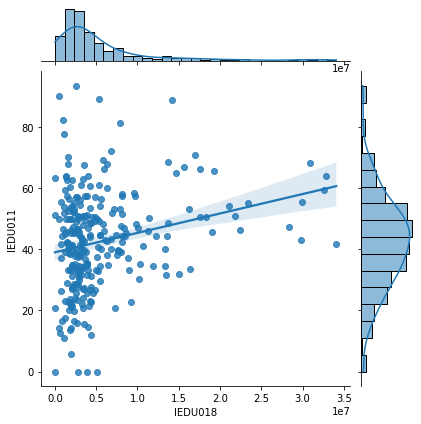

In [44]:
import seaborn as sns
sns.jointplot(x="IEDU018", y="IEDU011", data=data_final3, kind="reg")

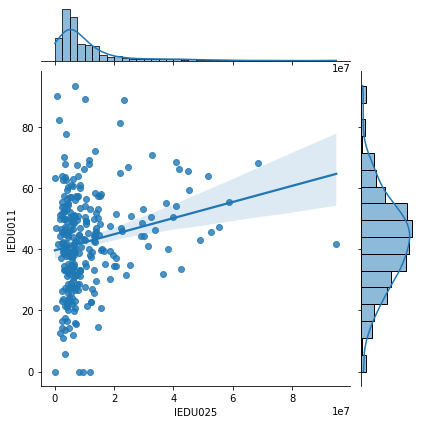

In [45]:
import seaborn as sns
sns.jointplot(x="IEDU025", y="IEDU011", data=data_final3, kind="reg")